# Giới thiệu

- Với dữ liệu về số lượng chuyến bay trì hoãn mỗi ngày được ghi nhận lại, ta mong muốn xây dựng một mô hình có khả năng dự báo được số lượng chuyến bay bị trì hoãn trong tương lai

- Mô hình cần nắm bắt được các biến động của dữ liệu trong quá khứ và dựa vào đó để đưa ra các dự báo phù hợp


----

# Dự báo với FBProphet

In [322]:
!python -m pip install prophet

# Import các thư viện cần thiết

In [323]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
plt.style.use('ggplot')

from sklearn.metrics import mean_squared_error
from prophet import Prophet

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Chuẩn bị dữ liệu

In [324]:
df = pd.read_csv('./Data/DelayedFlights_cleaned.csv')
df = df[df['Delayed'] == True]
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df

,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,...,TaxiIn,TaxiOut,Cancelled,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,Delayed,Timestamp
0,1,15,2,1948.0,19:05,2248.0,2217,XE,2597,N12996,...,9.0,11.0,0,31.0,0.0,0.0,0.0,0.0,True,2008-01-15 19:05:00
1,1,19,6,916.0,09:00,1204.0,1143,XE,1265,N14998,...,11.0,18.0,0,16.0,0.0,5.0,0.0,0.0,True,2008-01-19 09:00:00
2,1,20,7,1403.0,13:30,1625.0,1608,XE,1284,N16151,...,6.0,32.0,0,0.0,0.0,17.0,0.0,0.0,True,2008-01-20 13:30:00
3,1,31,4,1418.0,13:50,1810.0,1658,XE,2217,N29906,...,5.0,51.0,0,0.0,9.0,44.0,0.0,19.0,True,2008-01-31 13:50:00
4,1,2,3,1303.0,12:30,1557.0,1445,XE,2543,N16919,...,6.0,8.0,0,0.0,0.0,72.0,0.0,0.0,True,2008-01-02 12:30:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
163387,12,13,6,921.0,08:30,1112.0,1008,DL,1616,N907DE,...,8.0,21.0,0,51.0,0.0,13.0,0.0,0.0,True,2008-12-13 08:30:00
163388,12,13,6,1552.0,15:20,1735.0,1718,DL,1620,N905DE,...,9.0,7.0,0,0.0,0.0,0.0,0.0,17.0,True,2008-12-13 15:20:00
163389,12,13,6,1250.0,12:20,1617.0,1552,DL,1621,N938DL,...,9.0,18.0,0,3.0,0.0,0.0,0.0,22.0,True,2008-12-13 12:20:00
163390,12,13,6,657.0,06:00,904.0,749,DL,1631,N3743H,...,15.0,34.0,0,0.0,57.0,18.0,0.0,0.0,True,2008-12-13 06:00:00


In [325]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 143137 entries, 0 to 163391
Data columns (total 28 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Month              143137 non-null  int64         
 1   DayofMonth         143137 non-null  int64         
 2   DayOfWeek          143137 non-null  int64         
 3   DepTime            143137 non-null  float64       
 4   CRSDepTime         143137 non-null  object        
 5   ArrTime            143137 non-null  float64       
 6   CRSArrTime         143137 non-null  int64         
 7   UniqueCarrier      143137 non-null  object        
 8   FlightNum          143137 non-null  int64         
 9   TailNum            143137 non-null  object        
 10  ActualElapsedTime  143137 non-null  float64       
 11  CRSElapsedTime     143137 non-null  float64       
 12  AirTime            143137 non-null  float64       
 13  ArrDelay           143137 non-null  float64 

# Định dạng lại dữ liệu

Tiến hành bỏ các cột không cần thiết. Đối với mô hình FBProphet, ta chỉ cần 2 cột là thời gian và giá trị quan tâm tương ứng

In [326]:
df = df['Timestamp'].dt.date.value_counts().sort_index().reset_index()
df.columns = ['Date', 'Delays']
df.head()

,Date,Delays
0,2008-01-01,347
1,2008-01-02,785
2,2008-01-03,640
3,2008-01-04,315
4,2008-01-05,171


Trực quan dữ liệu gốc ban đầu

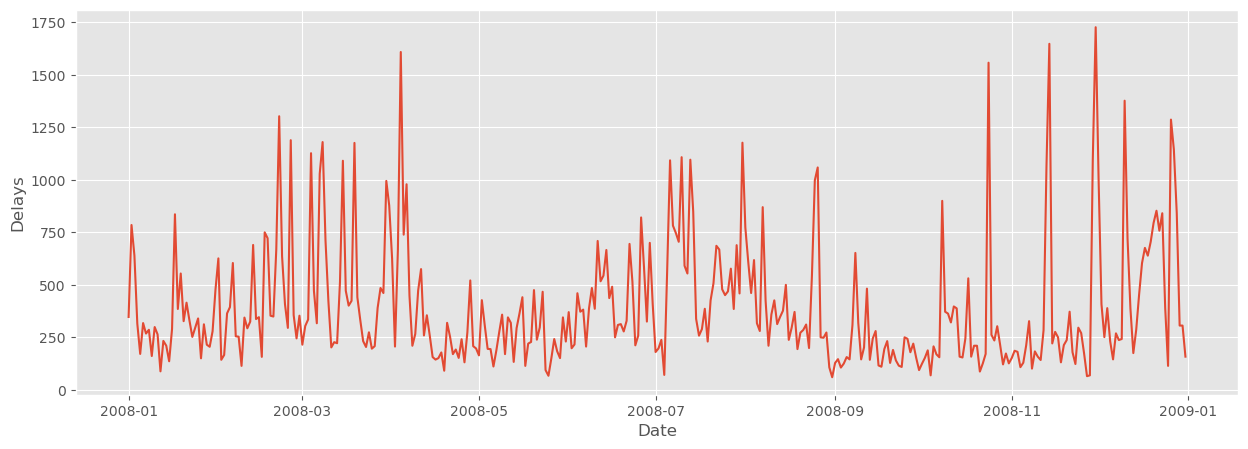

In [327]:
fig = plt.figure(figsize=(15, 5))
sns.lineplot(x='Date', y='Delays', data=df);

**Nhận xét**

- Dữ liệu dường như có tính mùa vụ, mỗi chu kì thường kéo dài khoảng 4 tháng

- Ví dụ như tháng 2 - tháng 5, có xu hướng tăng cao và giảm lại

Để thực hiện việc dự báo, ta dùng dữ liệu test sẽ là 5 tháng kế tiếp

In [328]:
test_df = pd.DataFrame(data=pd.date_range(start='2009-01-01', end='2009-05-1'),
                    columns=['ds'])
test_df.head()

,ds
0,2009-01-01
1,2009-01-02
2,2009-01-03
3,2009-01-04
4,2009-01-05


Để tăng sự chính xác cho mô hình, ta cũng cần cân nhắc đến yếu tố `holidays`. Số lượng chuyến bay trong thực tế có sự tăng giảm thay đổi dựa trên các ngày nghỉ.


In [329]:
cal = calendar()
holidays = cal.holidays(start=df['Date'].min(),
                        end=df['Date'].max(),
                        return_name=True)


In [330]:
holidays = holidays.reset_index()
holidays.columns = ['ds', 'holiday']
holidays

,ds,holiday
0,2008-01-01,New Year's Day
1,2008-01-21,"Birthday of Martin Luther King, Jr."
2,2008-02-18,Washington’s Birthday
3,2008-05-26,Memorial Day
4,2008-07-04,Independence Day
5,2008-09-01,Labor Day
6,2008-10-13,Columbus Day
7,2008-11-11,Veterans Day
8,2008-11-27,Thanksgiving Day
9,2008-12-25,Christmas Day


# Fit model

Đổi tên cột cho đúng với định dạng mà `FBProphet` yêu cầu

In [331]:
df.columns = ['ds', 'y']


In [332]:
model = Prophet(yearly_seasonality=True)
model.fit(df)

14:49:23 - cmdstanpy - INFO - Chain [1] start processing
14:49:24 - cmdstanpy - INFO - Chain [1] done processing


Trực quan trên dữ liệu quan sát được

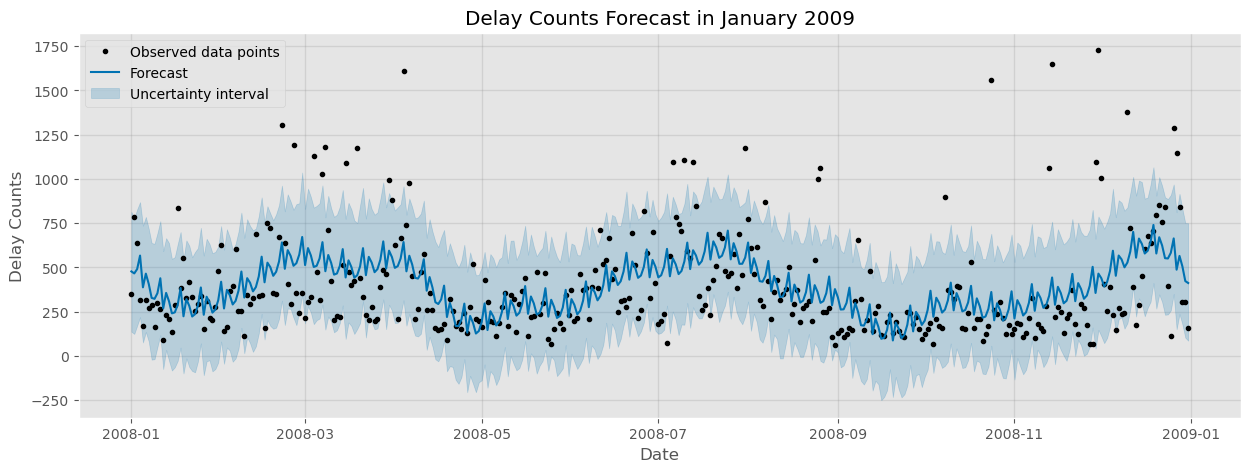

In [333]:
observed_predictions = model.predict(df)

fig, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(observed_predictions,
                 figsize=(15, 5),
                 ax=ax);
plt.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Delay Counts")
ax.set_title("Delay Counts Forecast in January 2009");

**Nhận xét**

- Đường dự báo có hình dạng khá phù hợp với dữ liệu mà ta quan sát được.

- Tuy nhiên, chưa dự báo tốt cho những ngày có số lượng delay cao đột biến

Dự báo trên dữ liệu test (T1-T5 năm sau)

In [334]:
test_df = model.make_future_dataframe(periods=150)
test_df = test_df[test_df['ds'].dt.year == 2009]
test_df

,ds
366,2009-01-01
367,2009-01-02
368,2009-01-03
369,2009-01-04
370,2009-01-05
...,...
511,2009-05-26
512,2009-05-27
513,2009-05-28
514,2009-05-29


In [335]:
future_predictions = model.predict(test_df)

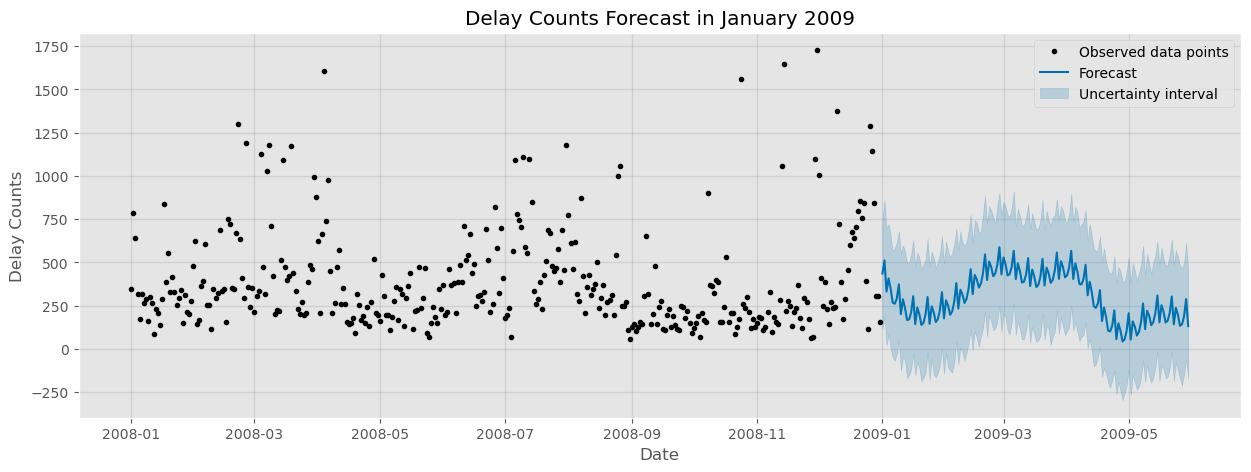

In [336]:
fig, ax = plt.subplots(figsize=(15, 5))
fig = model.plot(future_predictions,
                 figsize=(15, 5),
                 ax=ax,
                 );
plt.legend()
ax.set_xlabel("Date")
ax.set_ylabel("Delay Counts")
ax.set_title("Delay Counts Forecast in January 2009");

**Nhận xét**

- Vì số lượng chuyến bay và số lượng delay biến đổi khá giống nhau giữa các năm. Do đó, ta mong muốn mô hình có thể đưa ra dự báo có xu hướng tương tự như dữ liệu gốc

- Mô hình này đã thực hiện khá tốt việc này, có thể thấy từ T2 - T5 trong dữ liệu test có xu hướng khá giống với thời gian này ở năm trước đó.

Xem các thành phần của model

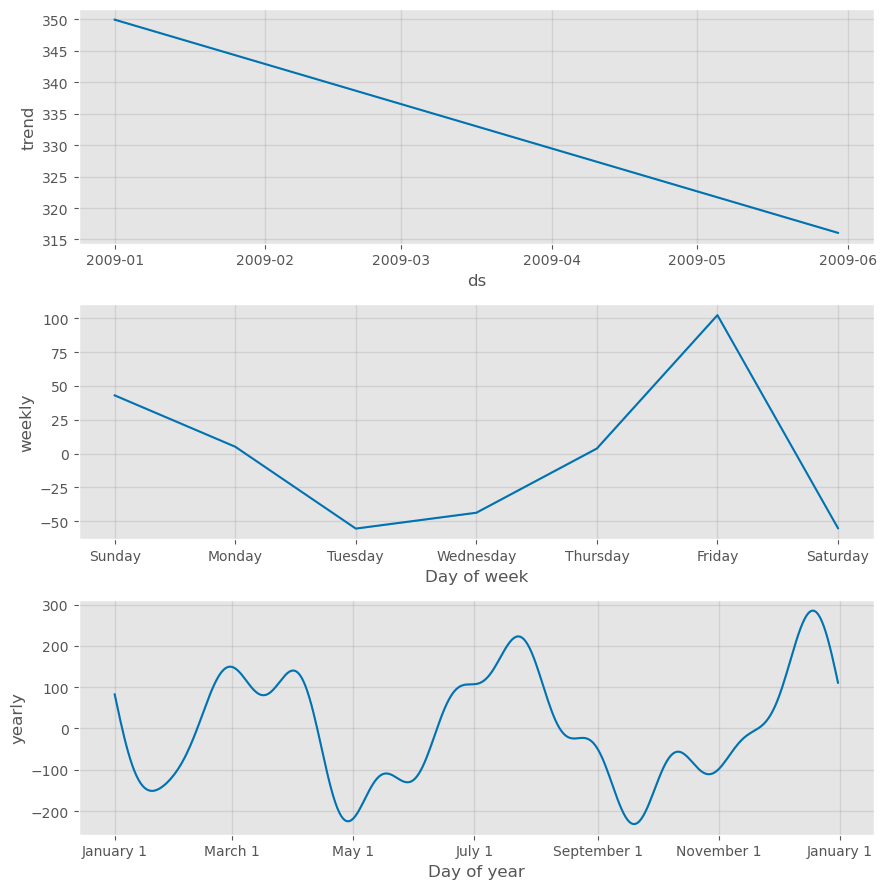

In [337]:
model.plot_components(future_predictions);

**Nhận xét**

- Có thể thấy, tính mùa vụ theo tuần cho thấy số lượng chuyến bay bị trì hoãn sẽ tăng cao kể từ ngày T3, có xu hướng giảm lại vào cuối tuần

- Tính mùa vụ theo năm của mô hình cho thấy mỗi chu kỳ thường kéo dài từ 4 tháng

# Đánh giá trên dữ liệu gốc

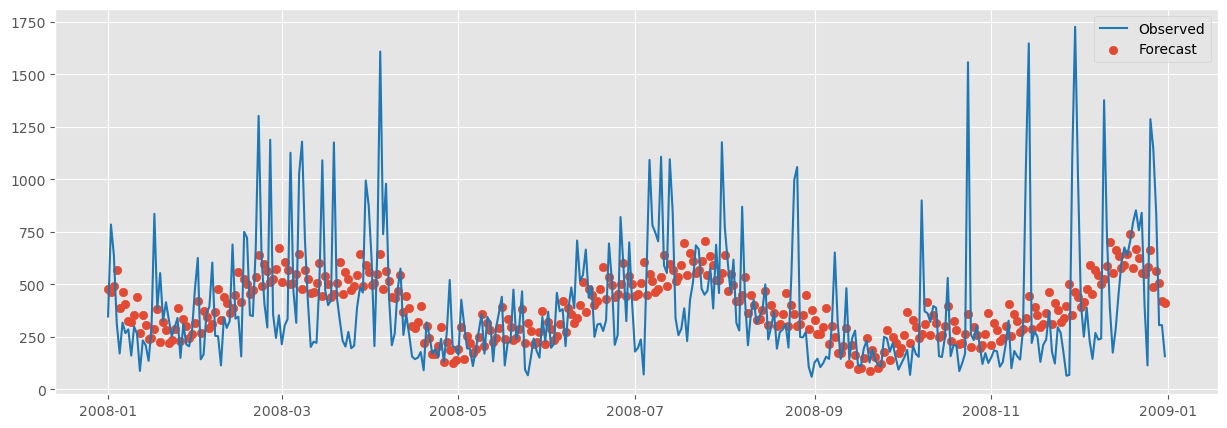

In [338]:
plt.figure(figsize=(15, 5)) 
plt.plot(df['ds'],df['y'], label='Observed', color='tab:blue')
plt.scatter(x=observed_predictions['ds'], y=observed_predictions['yhat'], label='Forecast')

plt.legend();

**Nhận xét**

- Các dự đoán của mô hình trên dữ liệu ban đầu khá khớp với xu hướng biến đổi của dữ liệu

- Tuy nhiên do sự biến động cao của dữ liệu nên mô hình chưa nắm bắt được các một số ngày có số lượng chuyến bay trì hoãn tăng đột ngột

**MSE trên dữ liệu quan sát**

In [339]:
score = mean_squared_error(y_true=df['y'], y_pred=observed_predictions['yhat'])
score

65584.83926761993

**RMSE trên dữ liệu quan sát**

In [340]:
np.sqrt(score)

256.0953714295124

**Nhận xét**

- Các giá trị MSE và RMSE tương đối cao vì dữ liệu khá biến động

- Tuy nhiên mô hình này dường như nắm bắt được các xu hướng tăng giảm có trong dữ liệu và đưa ra các dự đoán hợp lý

# Dự báo với XGBoost

Với các tiếp cận theo mô hình hồi quy theo kiểu ensemble. Thử xem mô hình này có thể dự báo tốt hơn so với `Prophet` hay không?

In [341]:
!pip install xgboost

In [342]:
import xgboost

Có thể xem bài toán dự báo như một mô hình hồi quy với:

- features: thời gian, có phải ngày lễ hay không...

- target: số lượng chuyến bay trì hoãn trong một ngày cụ thể

In [343]:
df['ds'] = pd.to_datetime(df['ds'])
holidays['ds'] = pd.to_datetime(holidays['ds'])

**Tạo một số features có liên quan**

In [344]:
df['Year'] = df['ds'].dt.year
df['Month'] = df['ds'].dt.month
df['Day'] = df['ds'].dt.day
df['Weekday'] = df['ds'].dt.day_of_week
df['Is Holidays'] = df['ds'].dt.date.isin(holidays['ds'].dt.date)


In [345]:
df.head()

,ds,y,Year,Month,Day,Weekday,Is Holidays
0,2008-01-01,347,2008,1,1,1,True
1,2008-01-02,785,2008,1,2,2,False
2,2008-01-03,640,2008,1,3,3,False
3,2008-01-04,315,2008,1,4,4,False
4,2008-01-05,171,2008,1,5,5,False


In [346]:
features = ['Year', 'Month', 'Day', 'Weekday', 'Is Holidays']
target = 'y'

In [347]:
X_train = df[features]
y_train = df[target]

**Chuẩn hoá dữ liệu**

In [348]:
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)

**Tìm các siêu tham số phù hợp**

In [349]:
xgb = xgboost.XGBRegressor()
kf = KFold(n_splits=3, shuffle=True, random_state=42)
param_grids = {
    'n_estimators': [200, 500],
    'max_depth': [10, 30, 50],
    'learning_rate': [0.01, 0.1, 1],
    'subsample': [0.5, 0.7],
    'colsample_bytree': [0.5, 0.7]
}

In [350]:
cv_model = GridSearchCV(estimator=xgb,
                        param_grid=param_grids,
                        cv=kf,
                        scoring='neg_mean_squared_error')

cv_model.fit(scaled_X_train, y_train)

GridSearchCV(cv=KFold(n_splits=3, random_state=42, shuffle=True),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    inte...
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.7],
                         'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [10, 30, 50], 'n_estimators': [200, 500],
                         'subsample': [0.5, 0.7]},
             scoring='neg_mean_squared_error')

# Đánh giá

Đầu tiên, xem thử dự báo của mô hình so với dữ liêu gốc

In [351]:
predictions = cv_model.predict(scaled_X_train)

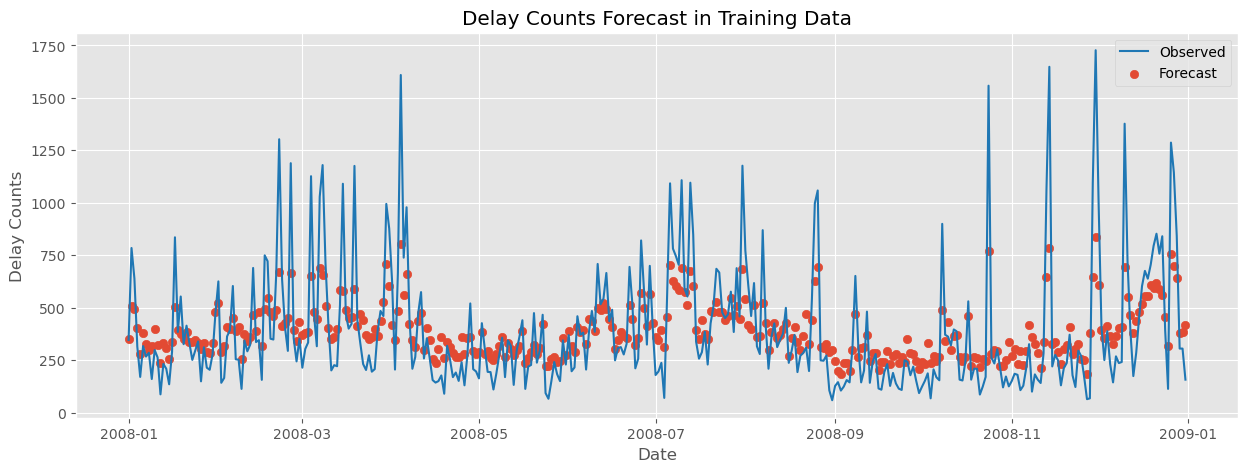

In [352]:
plt.figure(figsize=(15, 5))
plt.plot(df['ds'], df['y'], label='Observed', color='tab:blue')
plt.scatter(df['ds'], predictions, label='Forecast', )

plt.xlabel("Date")
plt.ylabel("Delay Counts")
plt.title("Delay Counts Forecast in Training Data")
plt.legend();

**Nhận xét**

- Các giá trị dự báo có xu hướng tăng giảm khá khớp với dữ liệu ban đầu

- Giữ được đặc trưng về tính mùa vụ của dữ liệu gốc

- Các giá trị dự báo nắm bắt khá tốt các xu hướng tăng giảm của dữ liệu

**Kiểm tra trên dữ liệu test**

In [353]:
test_df['Year'] = test_df['ds'].dt.year
test_df['Month'] = test_df['ds'].dt.month
test_df['Day'] = test_df['ds'].dt.day
test_df['Weekday'] = test_df['ds'].dt.day_of_week
test_df['Is Holidays'] = test_df['ds'].dt.date.isin(holidays['ds'].dt.date)

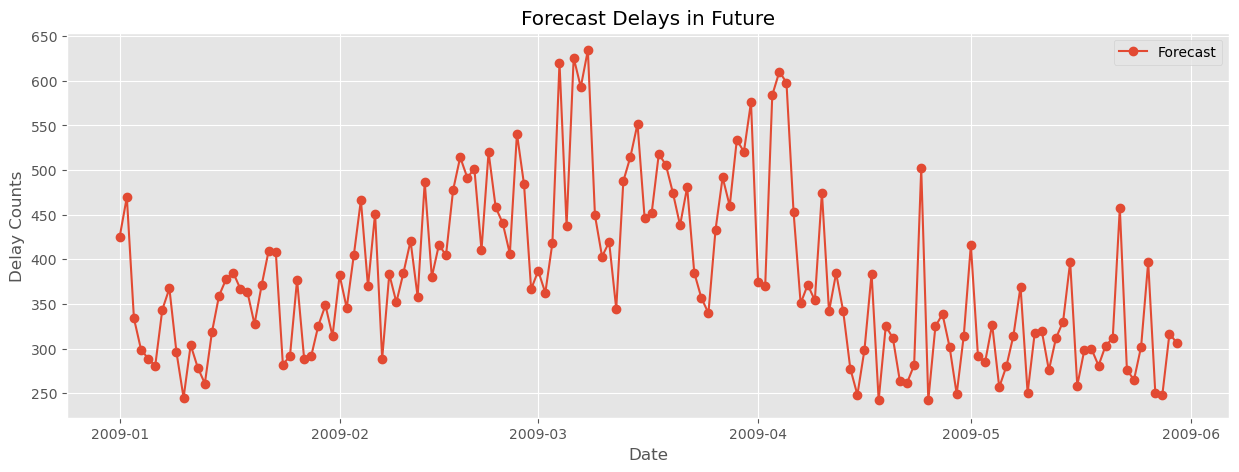

In [354]:
scaled_X_test = scaler.transform(test_df[features])
test_predictions = cv_model.predict(scaled_X_test)
plt.figure(figsize=(15, 5))
plt.plot(test_df['ds'], test_predictions, label='Forecast', marker='o');
plt.title('Forecast Delays in Future')
plt.xlabel('Date')
plt.ylabel('Delay Counts')
plt.legend();


**Nhận xét**

- Với mô hình này, dường như các đặc tính về mùa vụ vẫn được nắm bắt khá tốt

- Có xu hướng tăng giảm khá rõ ràng

**MSE trên tập dữ liệu quan sát**

In [355]:
score = mean_squared_error(y_true=df['y'], y_pred=predictions)
score

33361.471342841825

**RMSE trên dữ liệu quan sát**

In [356]:
np.sqrt(score)

182.65122869239568

**Nhận xét**

- Độ lỗi trên mô hình này là thấp hơn nhưng tính tổng quát lại không tốt bằng `FBProphet`. Đặc biệt các đặc tính về mùa vụ thì `FBProphet` thể hiện tốt hơn.

- Có thể cần thêm dữ liêu của nhiều năm hơn nữa và cần thêm các features quan trọng để cải thiện mô hình